In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

import os
import shutil

from google.colab import files
uploaded = files.upload()

Saving data_sres.xlsx to data_sres.xlsx


In [2]:
# Install optimization package
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00


In [3]:
# Data preprocessing -- normalization of model output

# Clear the previous TensorFlow/Keras session to reset the state of the backend
tf.keras.backend.clear_session()

# Optional: Clear previous results if needed
directory = 'hyperparam_tuning'
if os.path.exists(directory):
    shutil.rmtree(directory)

# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Extract actual data of input variables or features
Xall = pd.read_excel('data_sres.xlsx')
X = Xall[['concentration', 'aspectratio']]

# Extract the dependent variable or output or target variable
y = Xall['DependentVariable']

# Normalize y using Min-Max normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape y to 2D array for normalization
y = y.values.reshape(-1, 1)

# Initialize MinMaxScaler and normalize y
scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y)

# Combine the normalized dependent variable with the features matrix X (inputs)
# Create a new DataFrame with the normalized y, X_combined used later
X_combined = pd.DataFrame(np.hstack((X, y_normalized)), columns=['concentration', 'aspectratio', 'DependentVariable'])

# Use the combined matrix for further analysis or model building below
# Show the first few rows of the new matrix to ensure data is ready
print(X_combined.head())

# Split the data by adjusting test_size
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=random_seed)

   concentration  aspectratio  DependentVariable
0            5.0       316.15           0.462847
1            5.0       316.15           0.659803
2            5.0       316.15           1.000000
3            7.5       316.15           0.017010
4            7.5       316.15           0.018801


In [4]:
# Build XGBoost model With normalization of model output only
import optuna
import optuna.logging
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set logging level to WARNING to suppress trial outputs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function to optimize
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 5, 30, step=5)
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)

    # Create model with suggested parameters (removed use_label_encoder)
    model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=n_estimators,
                         max_depth=max_depth)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Return the mean squared error (the lower, the better, ideally)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model_xgb = XGBRegressor(objective='reg:squarederror', **best_params)
final_model_xgb.fit(X_train, y_train)

# Evaluate on Training Set
y_train_predxgb = final_model_xgb.predict(X_train)
mse_trainxgb = mean_squared_error(y_train, y_train_predxgb)
r_squared_trainxgb = r2_score(y_train, y_train_predxgb)

# Evaluate on Test Set
y_test_predxgb = final_model_xgb.predict(X_test)
mse_testxgb = mean_squared_error(y_test, y_test_predxgb)
r_squared_testxgb = r2_score(y_test, y_test_predxgb)

# Print Results
print(f'Mean Squared Error on Training Set: {mse_trainxgb}')
print(f'R-Squared Error on Training Set: {r_squared_trainxgb}')
print(f'Mean Squared Error on Test Set: {mse_testxgb}')
print(f'R-Squared Error on Test Set: {r_squared_testxgb}')

Best Parameters: {'n_estimators': 5, 'max_depth': 14}
Mean Squared Error on Training Set: 0.008717269186118044
R-Squared Error on Training Set: 0.8583943132899245
Mean Squared Error on Test Set: 0.0027425968062859316
R-Squared Error on Test Set: 0.9065895127055555


In [29]:
# XGBoost model built with normalization of output only  for -- Feature importances

importances = final_model_xgb.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
#print(importance_df)

# Save individual feature importances to new variables
feature1_importance_XGB = importance_df.loc[importance_df['Feature'] == 'aspectratio', 'Importance'].values[0]
feature2_importance_XGB = importance_df.loc[importance_df['Feature'] == 'concentration', 'Importance'].values[0]

print(f"Feature 1 (aspect ratio) Importance: {feature1_importance_XGB}")
print(f"Feature 2 (concentration) Importance: {feature2_importance_XGB}")


Feature Importances:
Feature 1 (aspect ratio) Importance: 0.6369988322257996
Feature 2 (concentration) Importance: 0.36300116777420044


In [20]:
# Build Kernel Ridge regression model With normalizaiton of model output only
import optuna
import optuna.logging
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Set logging level to WARNING to suppress trial outputs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*singular matrix.*")

# Define the objective function to optimize
def objective(trial):
    # Suggest hyperparameters using the updated method
    alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)  # Regularization strength (log scale)
    kernel = trial.suggest_categorical('kernel', ['linear', 'polynomial', 'rbf'])  # Kernel choice
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'polynomial' else 3  # Degree for polynomial kernel
    gamma = trial.suggest_float('gamma', 1e-6, 1e1, log=True) if kernel == 'rbf' else 1  # Gamma for rbf kernel

    # Create Kernel Ridge model with suggested parameters
    model = KernelRidge(alpha=alpha, kernel=kernel, degree=degree, gamma=gamma)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Return the mean squared error (the lower, the better)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model_krr = KernelRidge(alpha=best_params['alpha'],
                              kernel=best_params['kernel'],
                              degree=best_params.get('degree', 3),
                              gamma=best_params.get('gamma', 1))

final_model_krr.fit(X_train, y_train)

# Evaluate on Training Set
y_train_pred_krr = final_model_krr.predict(X_train)
mse_train_krr = mean_squared_error(y_train, y_train_pred_krr)
r_squared_train_krr = r2_score(y_train, y_train_pred_krr)

# Evaluate on Test Set
y_test_pred_krr = final_model_krr.predict(X_test)
mse_test_krr = mean_squared_error(y_test, y_test_pred_krr)
r_squared_test_krr = r2_score(y_test, y_test_pred_krr)

# Print Results
print(f'Mean Squared Error on Training Set: {mse_train_krr}')
print(f'R-Squared Error on Training Set: {r_squared_train_krr}')
print(f'Mean Squared Error on Test Set: {mse_test_krr}')
print(f'R-Squared Error on Test Set: {r_squared_test_krr}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=7.09075e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Best Parameters: {'alpha': 2.50175182290007e-05, 'kernel': 'polynomial', 'degree': 4}
Mean Squared Error on Training Set: 0.035285989543167695
R-Squared Error on Training Set: 0.42680480849875846
Mean Squared Error on Test Set: 0.004674560724301629
R-Squared Error on Test Set: 0.8407884840587235


In [36]:
# KRR model built with normalization of model output only for -- feature importance analysis

from sklearn.inspection import permutation_importance

# After fitting the final model with best parameters
final_model_krr.fit(X_train, y_train)

# Evaluate feature importance using permutation importance
result = permutation_importance(final_model_krr, X_test, y_test, n_repeats=10, random_state=random_seed)

# Print the feature importance scores (mean decrease in accuracy)
importance = result.importances_mean
for i, col in enumerate(X.columns):
    print(f"Feature '{col}' importance: {importance[i]}")

# Get the importance value for specific features
feature1_importance_krr = importance[X.columns.get_loc('concentration')]
feature2_importance_krr = importance[X.columns.get_loc('aspectratio')]

# Print the assigned importance values
print(f"Feature1 (concentration) Importance: {feature1_importance_krr}")
print(f"Feature2 (aspect ratio) Importance: {feature2_importance_krr}")


Feature 'concentration' importance: 1.1371665634455086
Feature 'aspectratio' importance: 1.295584647105801
Feature1 (concentration) Importance: 1.1371665634455086
Feature2 (aspect ratio) Importance: 1.295584647105801


In [38]:
# Build randome forest With normalization of model output only
import optuna
import optuna.logging
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Suppress specific warnings related to step adjustment
warnings.filterwarnings("ignore", category=UserWarning, message=".*step.*")

# Set logging level to WARNING to suppress trial outputs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the objective function to optimize
def objective(trial):
    # Suggest hyperparameters for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)  # Number of trees in forest
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Max depth of trees
    min_samples_split = trial.suggest_int('min_samples_split', 2, 19, step=2)  # Adjusted to avoid warnings
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 19, step=2)  # Adjusted to avoid warnings

    # Create model with suggested parameters
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Return the mean squared error (the lower, the better)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best parameters found by Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model_rf = RandomForestRegressor(**best_params, random_state=42)
final_model_rf.fit(X_train, y_train)

# Evaluate on Training Set
y_train_pred_rf = final_model_rf.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r_squared_train_rf = r2_score(y_train, y_train_pred_rf)

# Evaluate on Test Set
y_test_pred_rf = final_model_rf.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r_squared_test_rf = r2_score(y_test, y_test_pred_rf)

# Print Results
print(f'Mean Squared Error on Training Set: {mse_train_rf}')
print(f'R-Squared Error on Training Set: {r_squared_train_rf}')
print(f'Mean Squared Error on Test Set: {mse_test_rf}')
print(f'R-Squared Error on Test Set: {r_squared_test_rf}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Best Parameters: {'n_estimators': 20, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 1}
Mean Squared Error on Training Set: 0.03285455966258438
R-Squared Error on Training Set: 0.4663016154203218
Mean Squared Error on Test Set: 0.011058681247112694
R-Squared Error on Test Set: 0.6233508324084893


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Score: 0.544410867969944
Feature Importances:
         Feature  Importance
1    aspectratio    0.521776
0  concentration    0.478224


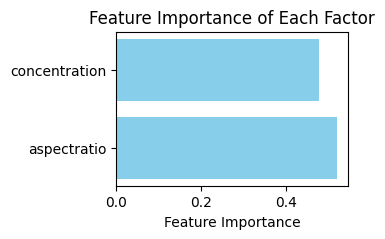

Feature 1 (aspect ratio) Importance: 0.5217758677201376
Feature 2 (concentration) Importance: 0.4782241322798624


In [39]:
# Radom forest model for feature importance

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the RandomForestRegressor with oob_score=True
final_model_rf = RandomForestRegressor(oob_score=True, random_state=42)

# Fit the model to the training data
final_model_rf.fit(X_train, y_train)

# Access and print the OOB score
oob_score = final_model_rf.oob_score_
print(f"OOB Score: {oob_score}")

# Access and print feature importances
feature_importances = final_model_rf.feature_importances_

# Create a DataFrame to display the importance values alongside feature names
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(3, 2))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Each Factor')
plt.show()

# Save individual feature importances to new variables
feature1_importance_rf = importance_df.loc[importance_df['Feature'] == 'aspectratio', 'Importance'].values[0]
feature2_importance_rf = importance_df.loc[importance_df['Feature'] == 'concentration', 'Importance'].values[0]

print(f"Feature 1 (aspect ratio) Importance: {feature1_importance_rf}")
print(f"Feature 2 (concentration) Importance: {feature2_importance_rf}")

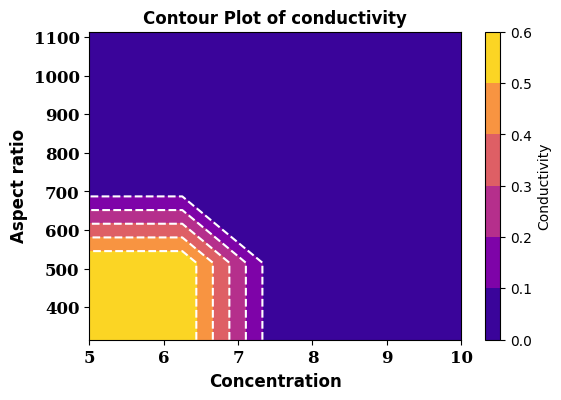

In [40]:
# Using XGBoost regression model for the contuour plot
# Using the model built with normalized output only

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data - this should be normalized data if
data = X_combined

# Define the factors
factor1Range = np.linspace(np.min(data['concentration']), np.max(data['concentration']), 5)
factor2Range = np.linspace(np.min(data['aspectratio']), np.max(data['aspectratio']), 5)

# Create a grid for Factor1 and Factor2
factor1Grid, factor2Grid = np.meshgrid(factor1Range, factor2Range)

# Create a grid of input data for prediction
inputGrid = pd.DataFrame({
    'concentration': factor1Grid.flatten(),
    'aspectratio': factor2Grid.flatten()
})

# Make sure replace with the model wanted for analysis, here XGBoost

# Make predictions on the grid
predictions = final_model_xgb.predict(inputGrid)

# Reshape predictions to match the grid dimensions
predictionsGrid = predictions.reshape(factor1Grid.shape)

# Create a 2D contour plot
plt.figure(figsize=(6, 4))

# Color map 'plasma' used for plotting
contourf = plt.contourf(factor1Grid, factor2Grid, predictionsGrid, 5, cmap='plasma')

# Add contour lines with custom line styles
contour = plt.contour(factor1Grid, factor2Grid, predictionsGrid, 5, colors='white', linestyles='dashed')

# Customize font and size for title, x-axis label, and y-axis label
plt.title('Contour Plot of conductivity', fontsize=12, fontweight='bold', fontfamily='sans-serif')
plt.xlabel('Concentration', fontsize=12, fontweight='bold', fontfamily='sans-serif')
plt.ylabel('Aspect ratio', fontsize=12, fontweight='bold', fontfamily='sans-serif')

# Show the colorbar
plt.colorbar(contourf, label='Conductivity')

# Customize font and size for x-axis and y-axis numbers
plt.xticks(fontsize=12, fontweight='bold', fontfamily='serif')
plt.yticks(fontsize=12, fontweight='bold', fontfamily='serif')

# Show the plot
plt.show()

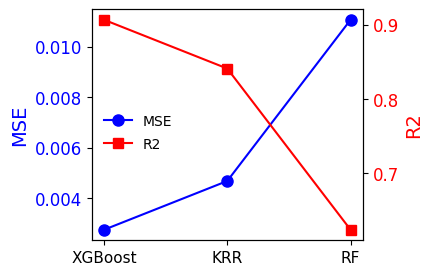

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Define the vectors based on the results for MSE and R2 from models above
v1 = np.array([mse_testxgb, mse_test_krr, mse_test_rf])
v2 = np.array([r_squared_testxgb, r_squared_test_krr, r_squared_test_rf])

# Define the x-axis (indices of the data points)
x = np.array([1, 2, 3])

# Create the figure and the first axis (for vector 1)
fig, ax1 = plt.subplots(figsize=(3.5, 3))

# Plot vector 1 on the first y-axis with tailored marker size (e.g., 8)
ax1.plot(x, v1, label='MSE', marker='o', color='b', markersize=8)
#ax1.set_xlabel('Data Points', fontsize = 14)
ax1.set_ylabel('MSE', color='b', fontsize = 14)
ax1.tick_params(axis='y', labelcolor='b', labelsize = 12)

# Create a second y-axis to share the same x-axis
ax2 = ax1.twinx()

# Plot vector 2 on the second y-axis with tailored marker size (e.g., 7)
ax2.plot(x, v2, label='R2', marker='s', color='r', markersize=7)
ax2.set_ylabel('R2', color='r', fontsize = 14)
ax2.tick_params(axis='y', labelcolor='r', labelsize = 12)

# Customize the x-axis to show only 1, 2, 3
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['XGBoost', 'KRR', 'RF'], fontsize=11)

# Add legends for both axes, placing them vertically on the left side, but shifting right
# Position the legends slightly to the right to avoid overlap with the y-axis
# Turn off the legend frame by setting frameon=False
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.6), labelspacing=1.5, frameon=False)  # Vector 1 legend
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.5), labelspacing=1.5, frameon=False)  # Vector 2 legend

# Add a title
#plt.title('Two Evaluation Metrics with Different Y-Axes')

# Display the plot
plt.show()

<Axes: >

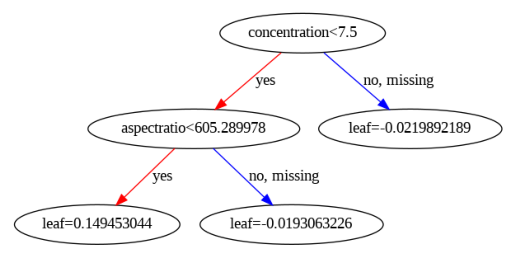

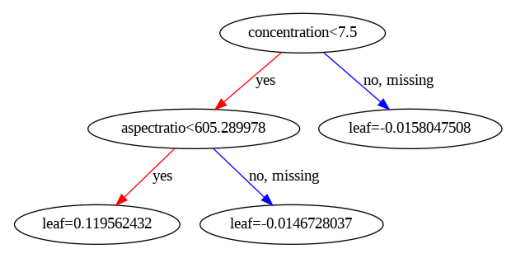

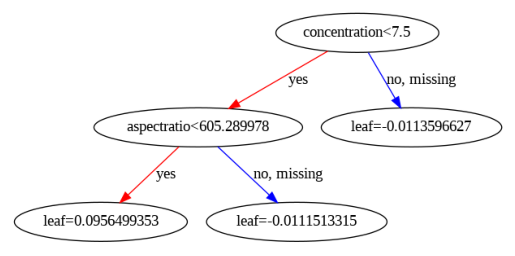

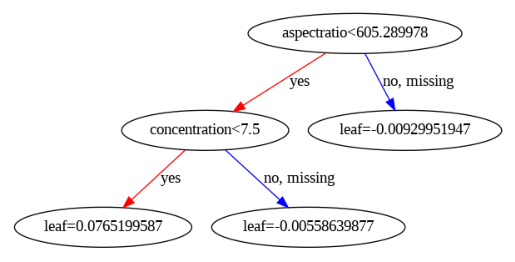

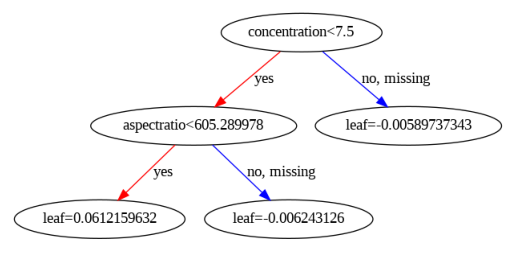

In [46]:
# Decision tree plotting

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot different trees of the XGBoost model
# Plot the 1st tree (index 0)
xgb.plot_tree(final_model_xgb, num_trees=0)

# Plot the 2nd tree (index 1)
xgb.plot_tree(final_model_xgb, num_trees=1)

# Plot the 3rd tree (index 2)
xgb.plot_tree(final_model_xgb, num_trees=2)

# Plot the 4th tree (index 3)
xgb.plot_tree(final_model_xgb, num_trees=3)

# Plot the 5th tree (index 4)
xgb.plot_tree(final_model_xgb, num_trees=4)

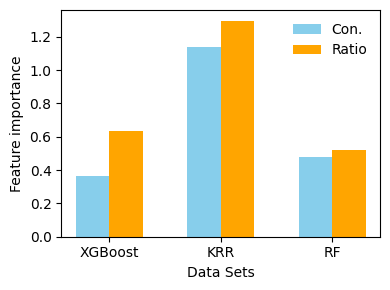

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Data from analysis above  -- feature importance
v1 = [feature2_importance_XGB, feature1_importance_XGB]
v2 = [feature1_importance_krr, feature2_importance_krr]
v3 = [feature2_importance_rf, feature1_importance_rf]

# Create an array for the positions of the bars on the x-axis
bar_width = 0.3  # Width of the bars
index = np.arange(3)  # The x positions for the sets of bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the bars for each set, ensuring no overlap within each set
ax.bar(index[0] - bar_width/2, v1[0], bar_width, color='#87CEEB')  # First bar for the first set
ax.bar(index[0] + bar_width/2, v1[1], bar_width, color='#FFA500')  # Second bar for the first set

ax.bar(index[1] - bar_width/2, v2[0], bar_width, color='#87CEEB')  # First bar for the second set
ax.bar(index[1] + bar_width/2, v2[1], bar_width, color='#FFA500')  # Second bar for the second set

ax.bar(index[2] - bar_width/2, v3[0], bar_width, color='#87CEEB')  # First bar for the third set
ax.bar(index[2] + bar_width/2, v3[1], bar_width, color='#FFA500')  # Second bar for the third set

# Set labels and title
ax.set_xlabel('Data Sets')
ax.set_ylabel('Feature importance')
#ax.set_title('Bar Plot with Three Data Sets')
ax.set_xticks(index)  # Center the x-ticks for each set
ax.set_xticklabels(['XGBoost', 'KRR', 'RF'])

# Add the legend only for the first set and position it at the top right corner
ax.legend(['Con.', 'Ratio'], loc='upper right', frameon=False)

# Show the plot
plt.tight_layout()
plt.show()
